<a href="https://colab.research.google.com/github/anilozdemir/RCax/blob/main/notebooks/esn_with_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Develop ESN using JAX

In [2]:
!pip install flax

     |████████████████████████████████| 193 kB 29.0 MB/s 
     |████████████████████████████████| 118 kB 56.0 MB/s 
     |████████████████████████████████| 57 kB 5.9 MB/s 


In [3]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen.activation import tanh
import optax
from flax.core import freeze, unfreeze

import matplotlib.pyplot as P 
import numpy as np

In [4]:
def createSparseMatrix(nRes, sparsity, seed):
    '''
    Utility function: creates Sparse Matrix
    Returns:
            W (np.array): sparse matrix of size (**nReservoir**, **nReservoir**).
    '''
    rows, cols = nRes, nRes
#     W = jax.random.uniform(jax.random.PRNGKey(0), shape = (rows, cols), minval=-1.0, maxval=1.0)
    np.random.seed(seed)
    W = np.random.uniform(-1, 1, (rows, cols)) # randomly chosen matrix, entries in range [-1,1]

    num_zeros = np.ceil(sparsity * rows).astype(np.int64) # number of zeros to set
    for iCol in range(cols):
        row_indices  = np.random.permutation(rows) # choose random row indicies
        zero_indices = row_indices[:num_zeros]     # get the num_zeros of them
        W[zero_indices, iCol] = 0                  # set (zero_indicies, iCol) to 0
    return jnp.asarray(W)


class ESN(nn.Module):
    nInput   : int
    nOutput  : int
    nRes     : int
    alpha    : float = 0.8
    rho      : float = 0.99
    sparsity : float = 0.90
    seed     : int   = 2
    
    def setup(self):
        self.W_in  = jax.random.normal(jax.random.PRNGKey(0), shape = (self.nRes, self.nInput))
        W          = createSparseMatrix(self.nRes, self.sparsity, self.seed)
        self.W_res = self.rho * W / (np.max(np.absolute(np.linalg.eigvals(W))))
        # self.W_out = nn.Dense(self.nOutput)
    
    def __call__(self, h, x):
        h_new = (1 - self.alpha) * h + self.alpha * tanh(self.W_res.dot(h) + self.W_in.dot(x))
        # y = self.W_out(h_new.T)
        return h_new #, y

In [24]:
nInput  = 1
nRes    = 100
alpha   = 0.4
nOutput = 1

hidden = jnp.zeros((nRes,1))
x      = jnp.ones((nInput, 1))
model  = ESN(nInput = nInput, nOutput=nOutput, nRes = nRes, alpha = alpha)
init_params = model.init(jax.random.PRNGKey(0), hidden, x)
# hidden = model.apply(init_params, hidden, x)
esn = model.bind(init_params)

## Visually Inspect The Hidden States

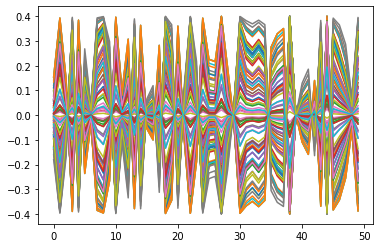

In [25]:
H = []
for key in range(50):
    x0 = jax.random.normal(jax.random.PRNGKey(key), shape = (nInput,1))
    H.append(esn(hidden,x0)[:,0])
P.plot(H);

In [26]:
# Network Function: Uses Hidden States and returns Output
def network(params, hidden):
  return jnp.dot(params, hidden)

params = jax.random.normal(jax.random.PRNGKey(0), shape = (nOutput, nRes))
print('initialized parameter shapes:\n', jax.tree_map(jnp.shape, unfreeze(params)))

def compute_loss(params, hidden, y_target): 
  return jnp.mean(optax.l2_loss(network(params, hidden), y_target))


initialized parameter shapes:
 (1, 100)


# Simple Regression: Reach to 1.0

In [32]:
# init the model and the parameters
hidden = jnp.zeros((nRes,1))
esn    = model.bind(init_params)
params = jax.random.normal(jax.random.PRNGKey(0), shape = (nOutput, nRes))

# define the optimiser
optimizer = optax.adam(0.1)
opt_state = optimizer.init(params)

# all predictions
All_Pred = []
# simple update loop
for i in range(200):
  # get hidden states
  hidden = esn(hidden,x)
  # calc gradients using the compute_loss function
  grads  = jax.grad(compute_loss)(params, hidden, 1.0)
  # update the optimiser
  updates, opt_state = optimizer.update(grads, opt_state)
  # update the parameters
  params = optax.apply_updates(params, updates)
  # get predictions
  All_Pred.append(network(params, hidden)[0,0])
  if (i+1) % 20 == 0: 
    print(i+1, All_Pred[-1])

20 -8.351988
40 0.514495
60 2.3847773
80 1.3296156
100 0.9982039
120 0.9738808
140 0.9880928
160 0.996667
180 0.99980736
200 1.0004914


# Simple Regression: Predict Sine Curve

In [33]:
# init the model and the parameters
hidden = jnp.zeros((nRes,1))
esn    = model.bind(init_params)
params = jax.random.normal(jax.random.PRNGKey(0), shape = (nOutput, nRes))

# define the optimiser
optimizer = optax.adam(0.05)
opt_state = optimizer.init(params)

# Sine Curve with N samples
N = 20
X = jnp.linspace(0,2*jnp.pi,N)
Y = jnp.sin(X)

Loss = []
# simple update loop
for i in range(2000):
  # get hidden states
  hidden = esn(hidden,Y[i%N])
  # get y_target
  y_target = Y[(i+1)%N]
  # calc gradients using the compute_loss function
  grads  = jax.grad(compute_loss)(params, hidden, y_target)
  # update the optimiser
  updates, opt_state = optimizer.update(grads, opt_state)
  # update the parameters
  params = optax.apply_updates(params, updates)
  # collect loss and print
  Loss.append(compute_loss(params, hidden, y_target))
  if (i+1) % 200 == 0: 
      print(f'iter: {i+1}\tloss: {jnp.array(Loss).mean():.3f}')
      Loss  = []

iter: 200	loss: 22.815
iter: 400	loss: 0.167
iter: 600	loss: 0.137
iter: 800	loss: 0.108
iter: 1000	loss: 0.084
iter: 1200	loss: 0.071
iter: 1400	loss: 0.140
iter: 1600	loss: 2.618
iter: 1800	loss: 1.401
iter: 2000	loss: 1.259


## Visualise the prediction

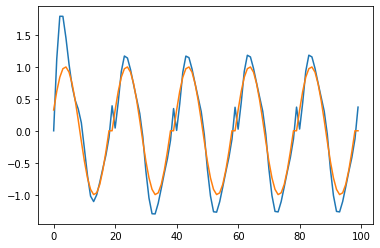

In [34]:
hidden = jnp.zeros((nRes,1))

Y_pred, Y_target = [], []
for i in range(100):
    hidden = esn(hidden,Y[i%N])
    Y_pred.append(network(params, hidden))
    Y_target.append( Y[(i+1)%N])

P.plot(jnp.array(Y_pred)[:,0,0])
P.plot(jnp.array(Y_target))    